# Supervised Machine Learning Model for Predicting Bank Churners

In this project, I am going to make models for predicting bank churners using both **Decision Tree Classifier** and **Random Forest Classifier**.

After that, I will also evaluate the performance of both models by plotting the **ROC-AUC curve** (Receiver Operating Characteristics-Area Under The Curve).

But first of all, I would like to thank **Sakshi Goyal** for providing the dataset in kaggle.com

The link for the data source is as follows:
https://www.kaggle.com/sakshigoyal7/credit-card-customers?select=BankChurners.csv

Written by: **Kevin Christian**


## Import Libraries

In [1]:
%matplotlib inline
import os
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

## Importing The Dataset

In [3]:
bc = pd.read_csv('BankChurners.csv')
bc.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than 40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Drop Irrelevant Columns

In this case, the **client id number** and the **naive_bayes_classifier_values** columns will not be relevant for our machine learning models.

In [4]:
bc.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace = True)

## Comparing The Frequency of Attrition Based on Several Features

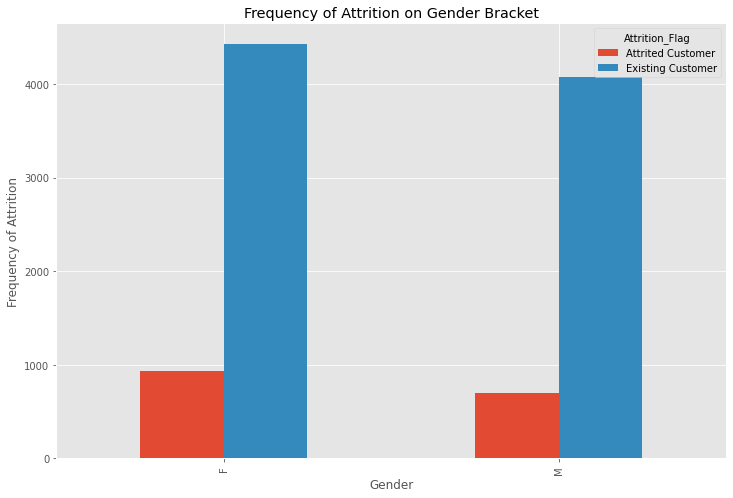

In [5]:
pd.crosstab(bc.Gender, bc.Attrition_Flag).plot(kind='bar')
plt.title('Frequency of Attrition on Gender Bracket')
plt.xlabel('Gender')
plt.ylabel('Frequency of Attrition')
plt.show()

It seems that the **distribution** of the attrited customers is **similar** in both male and female gender.

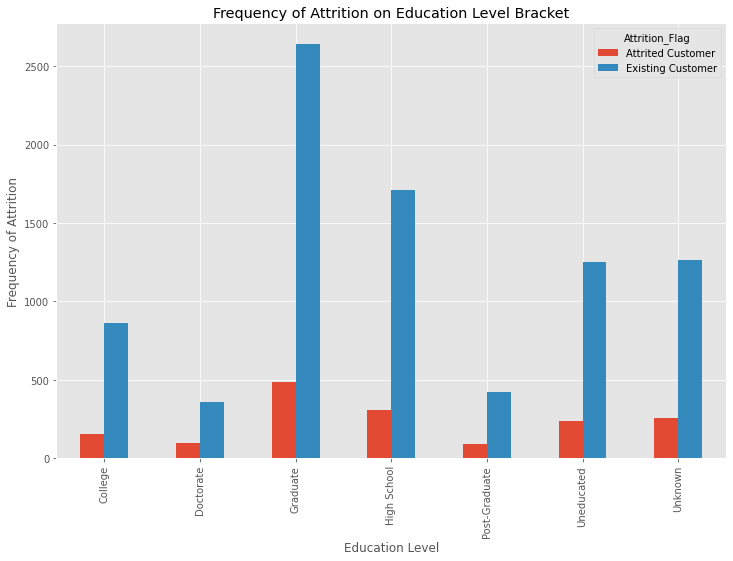

In [6]:
pd.crosstab(bc.Education_Level, bc.Attrition_Flag).plot(kind='bar')
plt.title('Frequency of Attrition on Education Level Bracket')
plt.xlabel('Education Level')
plt.ylabel('Frequency of Attrition')
plt.show()

It seems that **most** of the attrited customers are customers with an **education level** of "**Graduate**".

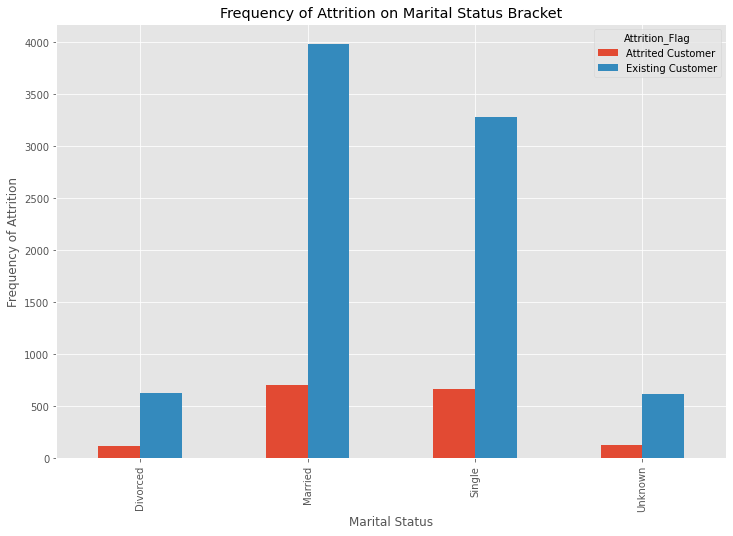

In [7]:
pd.crosstab(bc.Marital_Status, bc.Attrition_Flag).plot(kind='bar')
plt.title('Frequency of Attrition on Marital Status Bracket')
plt.xlabel('Marital Status')
plt.ylabel('Frequency of Attrition')
plt.show()

It seems that **most** of the attrited customers are customers with a **marital status** of either "**Married**" or "**Single**".

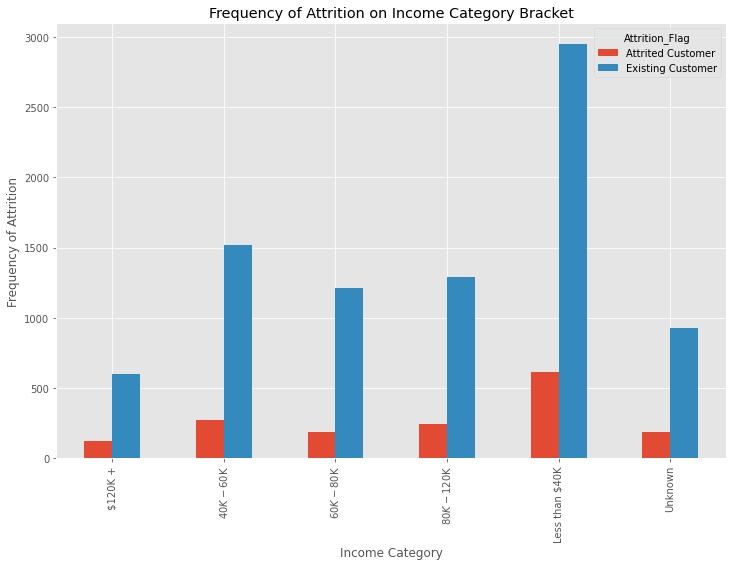

In [8]:
pd.crosstab(bc.Income_Category, bc.Attrition_Flag).plot(kind='bar')
plt.title('Frequency of Attrition on Income Category Bracket')
plt.xlabel('Income Category')
plt.ylabel('Frequency of Attrition')
plt.show()

It seems that **most** of the attrited customers are customers with an **income category** of "**Less than $40K**".

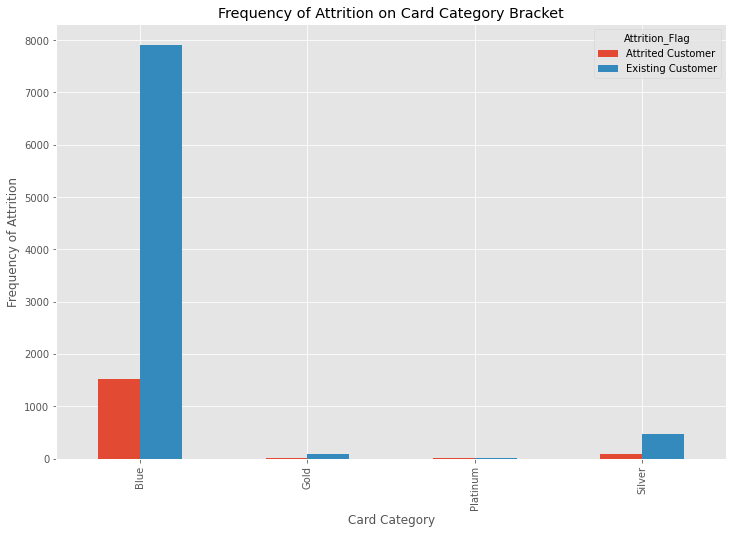

In [9]:
pd.crosstab(bc.Card_Category, bc.Attrition_Flag).plot(kind='bar')
plt.title('Frequency of Attrition on Card Category Bracket')
plt.xlabel('Card Category')
plt.ylabel('Frequency of Attrition')
plt.show()

It seems that **most** of the attrited customers are customers with a **card category** of "**Blue**".

## Encode Categorical Features

Usually, **scikit-learn** is not able to read **categorical data** from the dataset. 

Therefore, it is important for us **to encode** those categorical data such that it is **readable** by the **scikit-learn**. 

In this case, we are going to use the **get_dummies** feature from the **Pandas library**.

In the encoding process, **each categorical data** will be converted into **binary classification**. For instance, observe the **education level** feature. We see that there are **5 unique values**, which are "College", "Doctorate", "Graduate", "High School", and "Post-Graduate". So, **5 new columns** will be created which are "**Education_Level_College**", "**Education_Level_Doctorate**", etc. 

Now let's observe the **2nd row** of the dataset. Since the **education level** of the 2nd row is "**Graduate**", then the value of the "**Education_Level_Graduate**" feature will be **1**, while **the rest of the 4 new columns** will be **0**.

In [10]:
cat_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for var in cat_vars:
	cat_list = pd.get_dummies(bc[var], prefix=var)
	bc = bc.join(cat_list)

In [11]:
bc.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than 40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,Existing Customer,49,F,5,Graduate,Single,Less than 40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,Existing Customer,40,F,4,High School,Unknown,Less than 40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


Now, we should drop the columns which have categorical datatypes.

In [12]:
bc.drop(columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], axis = 1, inplace = True)

In [13]:
bc.head()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,Existing Customer,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,Existing Customer,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,Existing Customer,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,Existing Customer,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,Existing Customer,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


## Visualize Class Imbalance

In this part, we are going to see **the distribution** of the **Flag_Attrited** feature in the dataset.

In [14]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f611cd54b70>,
             labels=array(['Existing Customer', 'Attrited Customer'], dtype=object))

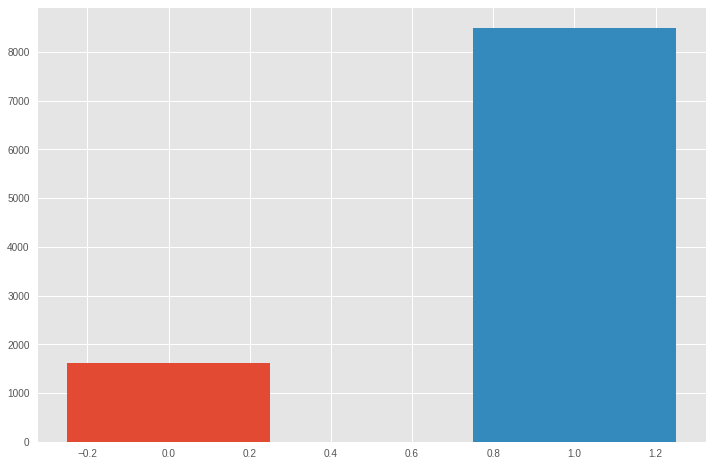

In [15]:
visualizer = ClassBalance(labels=bc.Attrition_Flag.unique()).fit(bc.Attrition_Flag)
visualizer

From the graph above, we can say that the dataset is **not distributed evenly** (Imbalanced) between the two values of the **Flag_Attrited** feature.

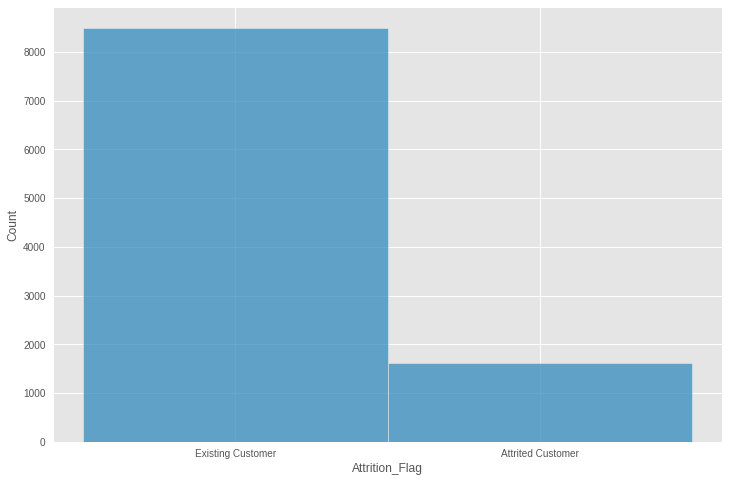

In [16]:
sns.histplot(bc.Attrition_Flag)

The graph above is only used to clarify the label of the bar graph ("Existing Customer" and "Attrited Customer").

## Create Training and Test Sets

Since the "**Flag_Attrited**" feature is **not distributed evenly** in the dataset. We will need to use the **stratified sampling**, so that the **training dataset** and the **testing dataset** have **similar distribution** of the "**Flag_Attrited**" feature.

In [17]:
X = bc.loc[:, bc.columns != 'Attrition_Flag']
y = bc.Attrition_Flag

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2, stratify = y)

## Build an Interactive Decision Tree Classifier

**Decision Tree Classifier** can be said as one of the most common type of **supervised learning algorithms**.

In this type of machine learning, data is **continuously split** according to **its parameters**.

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [20]:
@interact
def plot_tree(crit=['gini', 'entropy'], 
              split = ['best', 'random'], 
              depth=IntSlider(min=1, max=30, value=2, continuous_update=False), 
              min_split=IntSlider(min=2, max=5, value=2, continuous_update=False), 
              min_leaf=IntSlider(min=1, max=5, value=1, continuous_update=False)):
  
  estimator = DecisionTreeClassifier(random_state=0, criterion=crit, splitter=split, max_depth=depth, min_samples_split=min_split, min_samples_leaf=min_leaf)
  estimator.fit(X_train, y_train)
  
  print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
  print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
  
  graph = Source(tree.export_graphviz(estimator, out_file=None, feature_names=X_train.columns, class_names=estimator.classes_, filled=True))
  display(Image(data=graph.pipe(format='png')))
  return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Since this code is not executable in github, you may try to run this code in either the **Jupyter Notebook** or the **Google Colab**.

After your execution has been successful, you **will be able to adjust the feature** of the model like in the picture below:

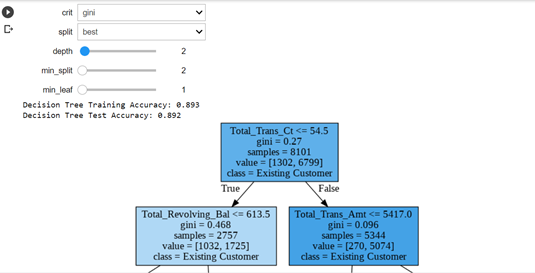

If you fail to import some of the libraries, I recommend you to check whether the libraries have been installed in your Google Colab or your Jupyter Notebook.

I chose to set the **continuous_update** to be **false** so that a new tree will be created **once you release your cursor** from the slider. This method **shortens the execution time** and **saves some memory**. The reason is that the computer system does not have to generate a new tree everytime you move your cursor in the slider.

## Build an Interactive Random Forest Classifier

In this type of machine learning, **multiple decision trees** are created. 

Eventually, it will **combine** the output of **each decision tree** to optimize the **final output**.

In [21]:
@interact
def plot_tree_rf(crit=['gini', 'entropy'], 
                 bootstrap=['True', 'False'], 
                 depth = IntSlider(min=1, max=30, value=3, continuous_update=False), 
                 forests = IntSlider(min=1, max=200, value=100, continuous_update=False), 
                 min_split = IntSlider(min=2, max=5, value=2, continuous_update=False), 
                 min_leaf = IntSlider(min=1, max=5, value=1, continuous_update=False)):
  estimator = RandomForestClassifier(random_state=1, criterion=crit, bootstrap=bootstrap, n_estimators=forests, max_depth=depth, min_samples_split=min_split, min_samples_leaf=min_leaf, n_jobs=-1, verbose=False)
  estimator.fit(X_train, y_train)
  print('Random Forests Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
  print('Random Forests Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
  
  num_tree = estimator.estimators_[0]
  print('\Visualizing Tree:', 0)
  
  graph = Source(tree.export_graphviz(num_tree, out_file=None, feature_names=X_train.columns, class_names=estimator.classes_, filled=True))
  
  display(Image(data=graph.pipe(format='png')))
  
  return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In this part, you will be able to **adjust the feature** of **the Random Forest Classifier** after you have successfully execute this code in either your **Jupyter Notebook** or your **Google Colab**.

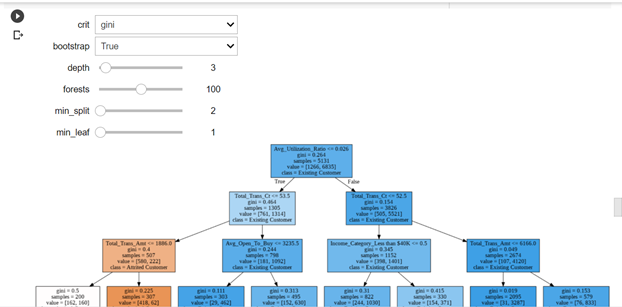

## Feature Importance and Evaluation Metrics

In this part, we are going to determine the **most impactful feature** for each model.

In [22]:
from yellowbrick.features import FeatureImportances
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use("ggplot")

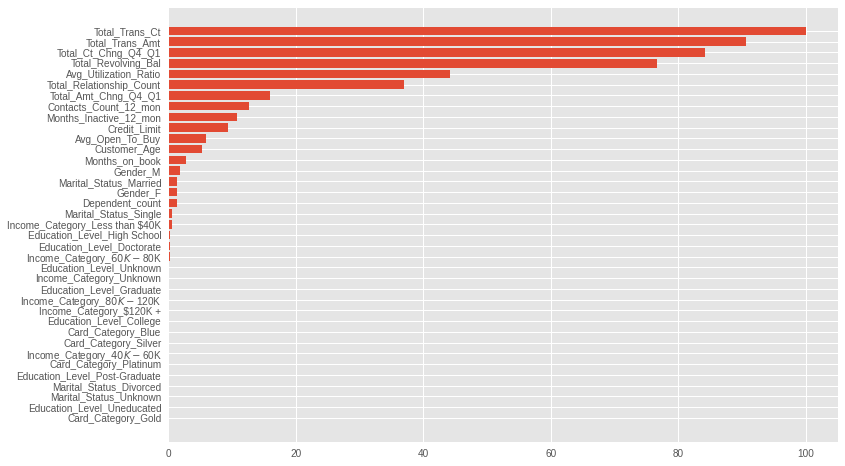

In [23]:
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz;

From the visualization above, we can see that the **the number of transactions (Total_Trans_Ct)** is the most **influential feature** for the **Random Forest Classifier**.

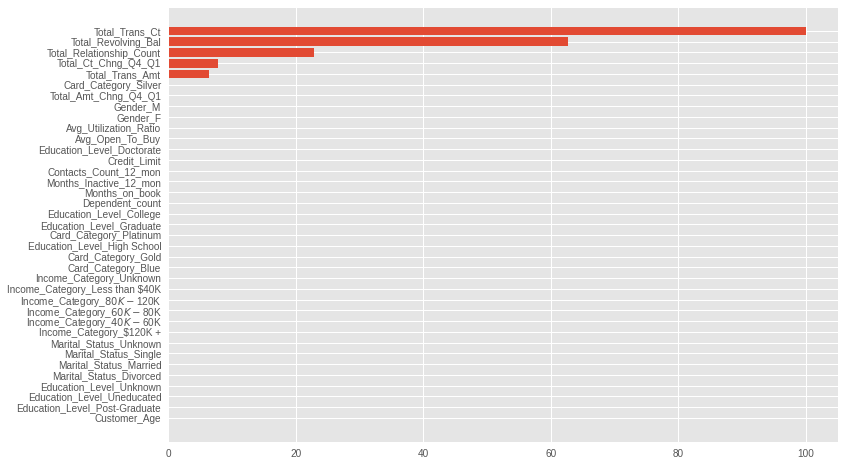

In [24]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz;

From the bar graph above, we can see that it looks **totally different** from the previous bar graph. But, we can still observe that **the number of transactions (Total_Trans_Ct)** is also the **most influential feature** for the the **Decision Tree Classifier**.

## ROC-AUC Curve of The Random Forest Classifier and The Decision Tree Classifier

In this part, we are going to **evaluate the performance** of each model by plotting its **ROC-AUC graph**.

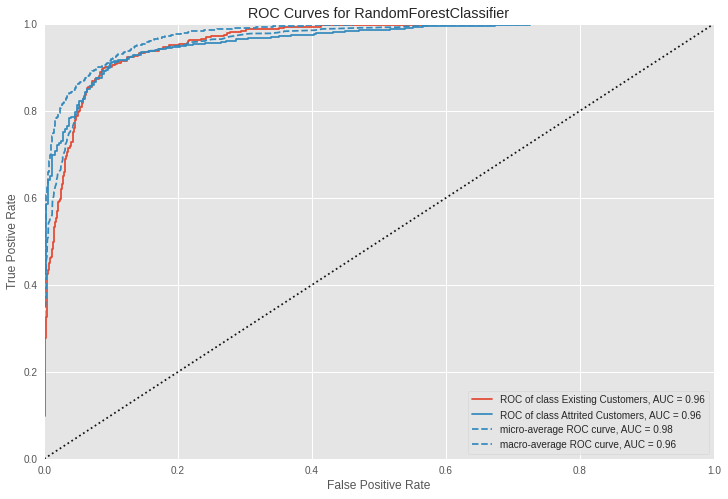

In [25]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf, classes=['Existing Customers', 'Attrited Customers'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

The curve above shows the **performance** of the **Random Forest Classifier**.

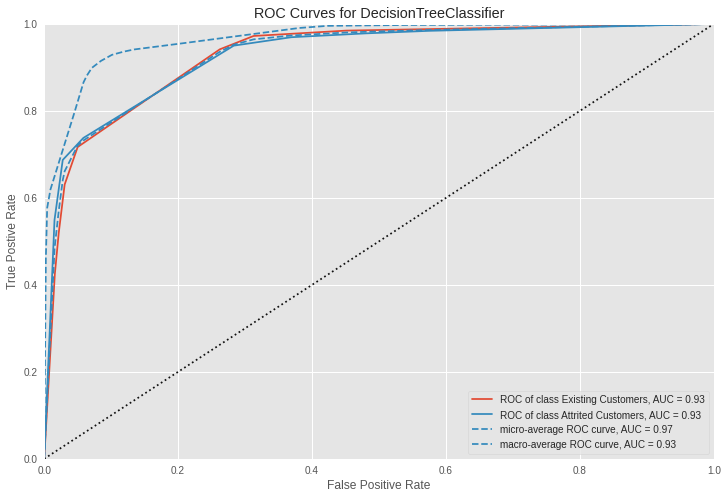

In [26]:
visualizer = ROCAUC(dt, classes=['Existing Customers', 'Attrited Customers'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

The curve above shows the **performance** of the **Decision Tree Classifier**.

From the 2 graphs above, we can say that the **Random Forest Classifier** performes better than the **Decision Tree Classifier**.

## Making Use of The Machine Learning Models for Predicting the Bank Churners

In this part, I am going to demonstrate on **how to use** the machine learning models **for predicting** Bank Churners. 

For the sake of the demonstration, I will use some rows from the **test dataset** so that the models **won't know** the real output.

In [30]:
real_output = y_test.head()
print("The real output:\n")
print(real_output)

The real output:

7230    Existing Customer
1394    Existing Customer
2967    Attrited Customer
7892    Existing Customer
6725    Existing Customer
Name: Attrition_Flag, dtype: object


In [31]:
input = X_test.head()

Predicting the output using the Decision Tree Classifier

In [32]:
predicted_output_dt = dt.predict(input)
print('The predicted output by the decision tree classifier:\n')
print(predicted_output_dt)

The predicted output by the decision tree classifier:

['Existing Customer' 'Existing Customer' 'Attrited Customer'
 'Existing Customer' 'Existing Customer']


Predicting the output using the Random Forest Classifier

In [33]:
predicted_output_rf = rf.predict(input)
print(predicted_output_rf)

['Existing Customer' 'Existing Customer' 'Attrited Customer'
 'Existing Customer' 'Existing Customer']


## Conclusion

In conclusion, we can make several differences between the Decision Tree Classifier and the Random Forest Classifier as follow:

1. the Random Forest Classifier has a **better performance** compared to the Decision Tree Classifier. 

2. However, Random Forest Classifier **requires longer training time**.

3. The Decision Tree Classifier is **easier to be interpreted**.

4. The Random Forest Classifier is **best in use** for **large datasets**.

**Well done**, you have reached the end of my project.

**Thank you** for taking a look at my project.

I hope that you may gain some insights for your **data science knowledge**.

If there are any **incorrect information**, do feel free to provide a **feedback** to me.